# MRI to Nissl registration example

This example uses a subset of a serial section nissl dataset.

In [1]:
# %matplotlib inline
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import os
from datetime import datetime

# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [2]:
# maybe I want to use the exvivo, not the atlas. that can be a version 2.
atlas_name = '/home/brysongray/data/Allen_Atlas_vtk/ara_nissl_100.vtk'
label_name = '/home/brysongray/data/Allen_Atlas_vtk/annotation_100.vtk'
target_name = '/home/brysongray/data/MD816_mini/MD816_STIF_mini_v2'
config_file = 'config787small.json'
time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S")
output_dir = '787_small_test_outputs_'+time



In [3]:
atlas_name = "/home/dtward/bmaproot/ifshome/bgray/data/MD816_mini/HR_NIHxCSHL_50um_14T_M1.vtk"
target_name = "/home/dtward/bmaproot/ifshome/bgray/data/MD816_mini/MD816_STIF_mini"
config_file = 'config787mini_mri_to_nissl.json'
time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S")
output_dir = '787_mini_test_outputs_'+time
output_dir = '787_mini_test_outputs'

In [4]:
# note about downsampling
# atlas is size 50x50x50
# data is size 14.74*3x14.72*3x200 (i.e. 10 micron, downsampled by a factor of 20)

In [5]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

In [6]:
downIs,downJs

([[4, 4, 4], [2, 2, 2]], [[1, 4, 4], [1, 2, 2]])

[50. 50. 50.]


<IPython.core.display.Javascript object>


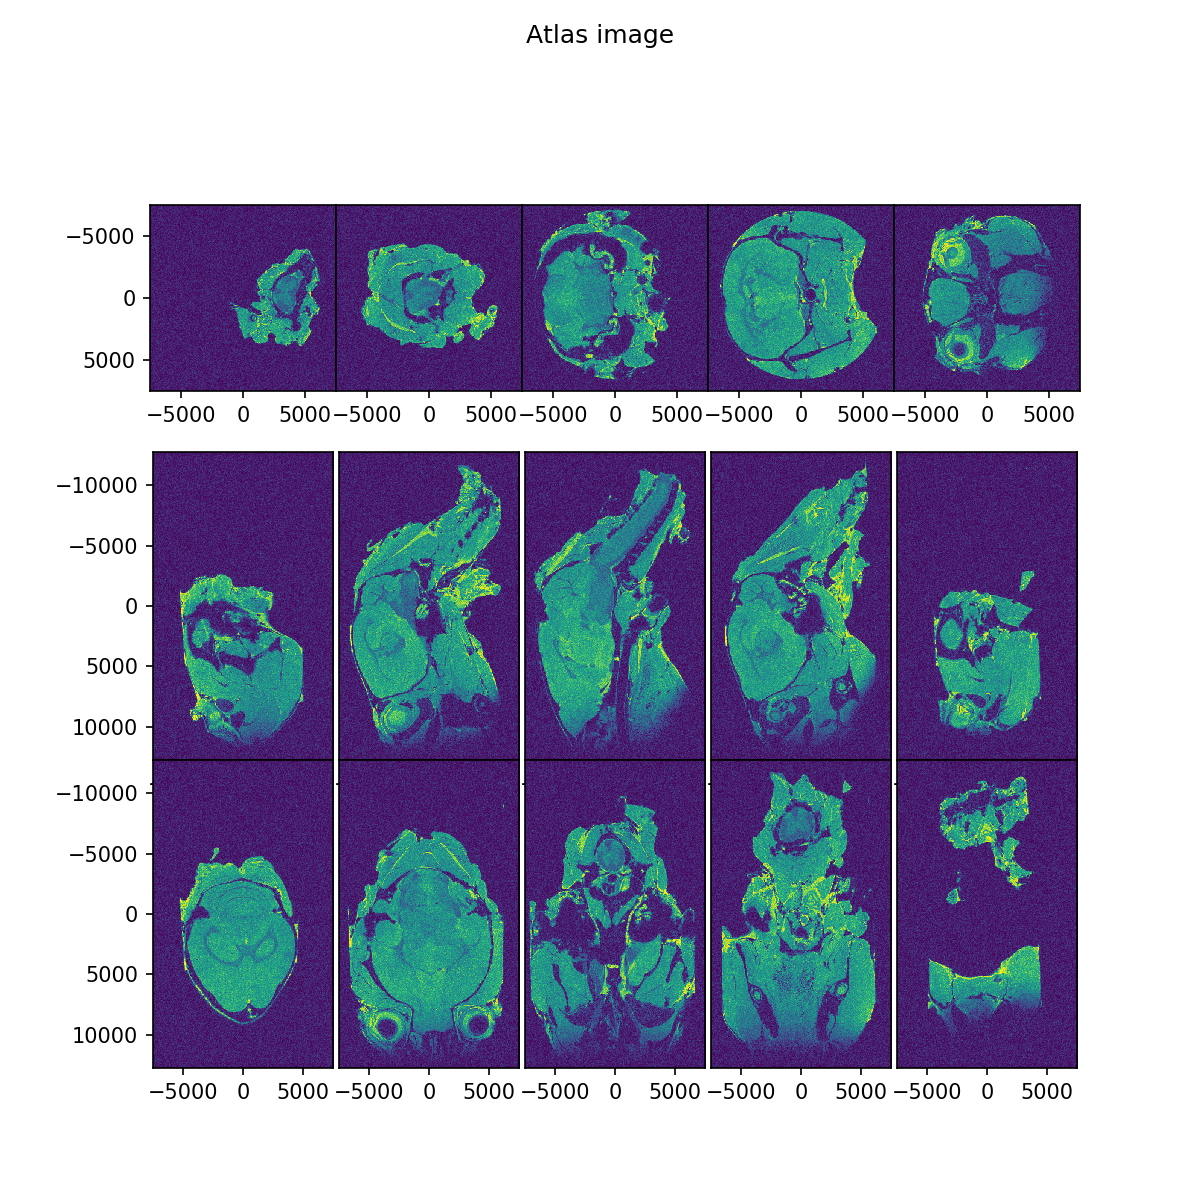

In [7]:
plt.rcParams["figure.figsize"] = (8,8)
# atlas
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')
fig[0].canvas.draw()

In [8]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[100.0, 100.0, 100.0]


loading target images


<IPython.core.display.Javascript object>


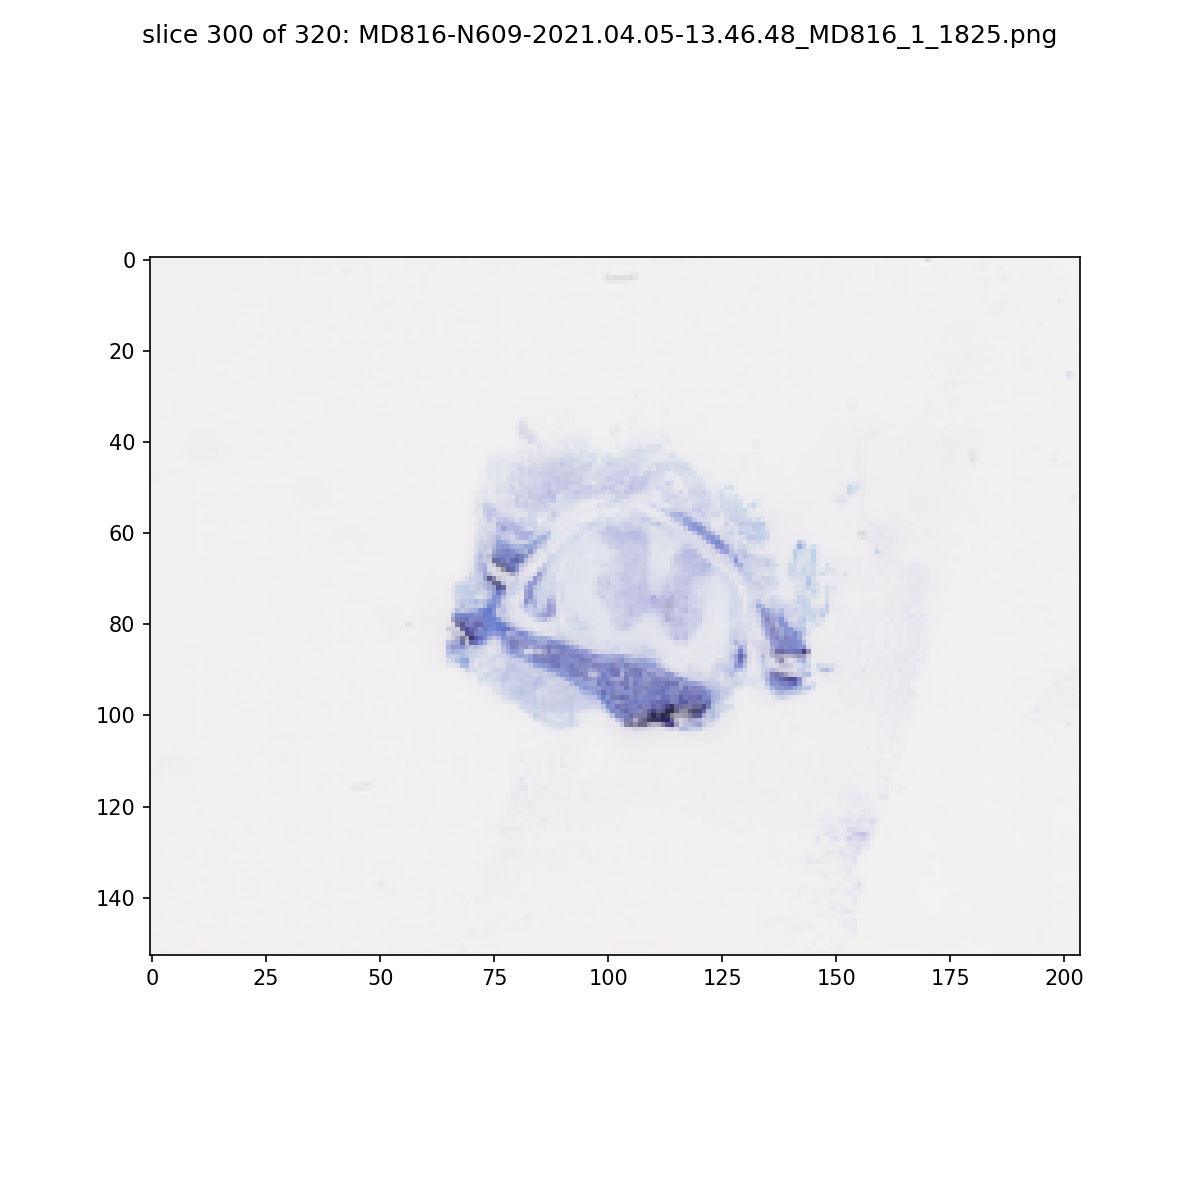

padding and assembling into 3D volume
[60.   58.88 58.88]


<IPython.core.display.Javascript object>


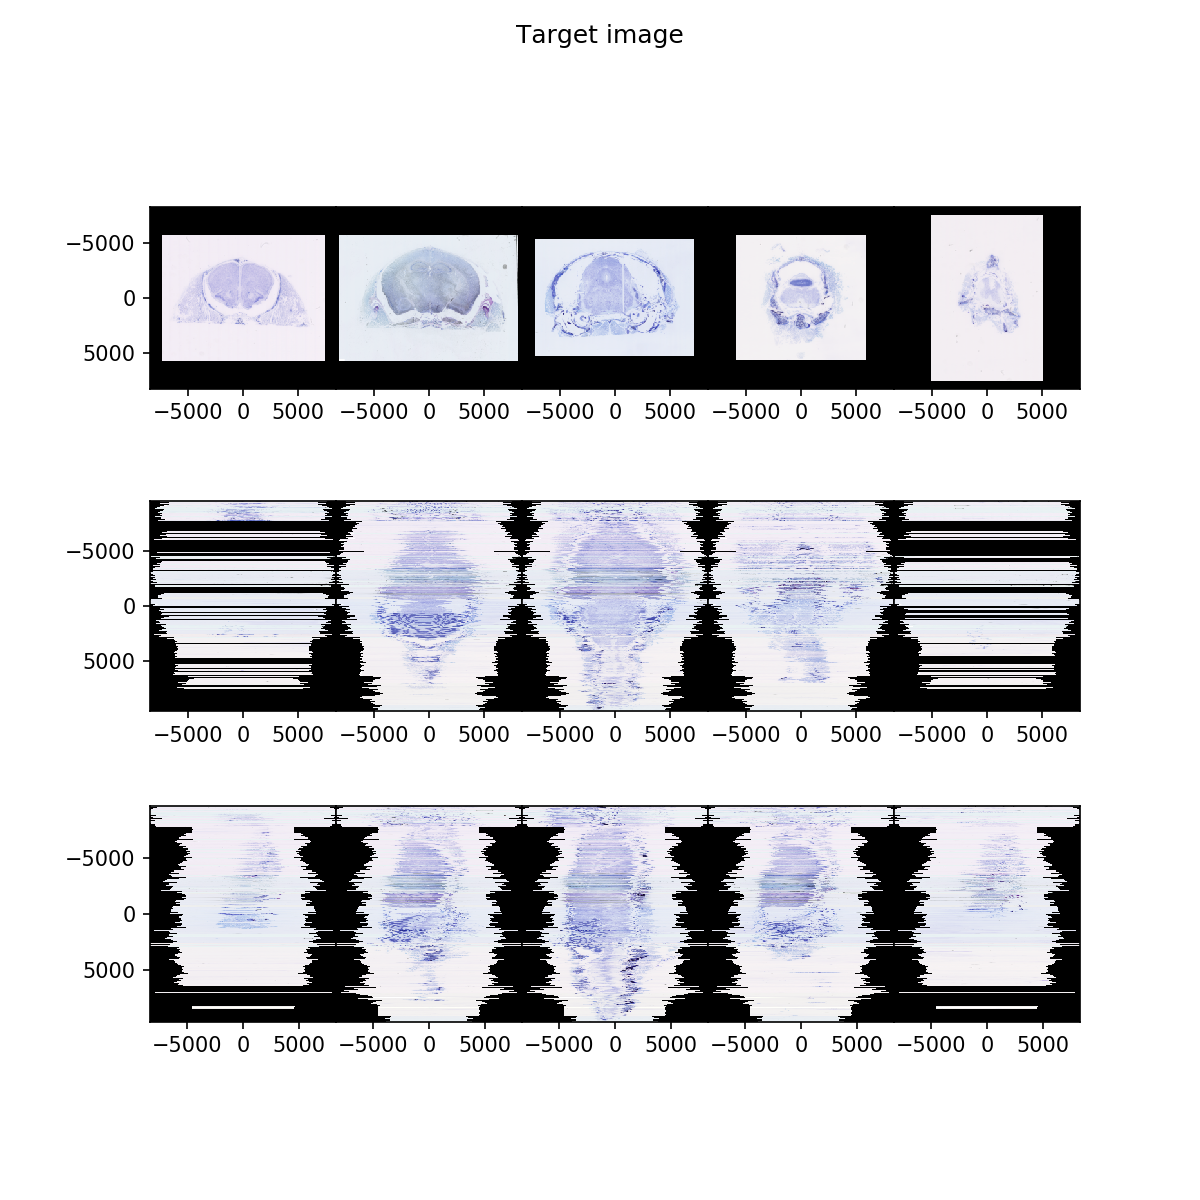

In [9]:
# target
imp.reload(emlddmm)
mindownJ = np.min(np.array(downJs),0)
# use 'down' argument for downsampling while loading into volume
# print('initial downsampling factor: ', mindownJ)
# xJ,J,title,names = emlddmm.read_data(target_name, down= list(mindownJ))
xJ,J,title,names = emlddmm.read_data(target_name)
if 'mask' in names:
    maskind = names.index('mask')
    W0 = J[maskind]
    J = J[np.arange(J.shape[0])!=maskind]    
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)
#J /= np.mean(np.abs(J)) # it is already 0,1 normalized

fig = emlddmm.draw(J,xJ)#, vmin=0, vmax=1)
fig[0].suptitle('Target image')
fig[0].canvas.draw()

<IPython.core.display.Javascript object>


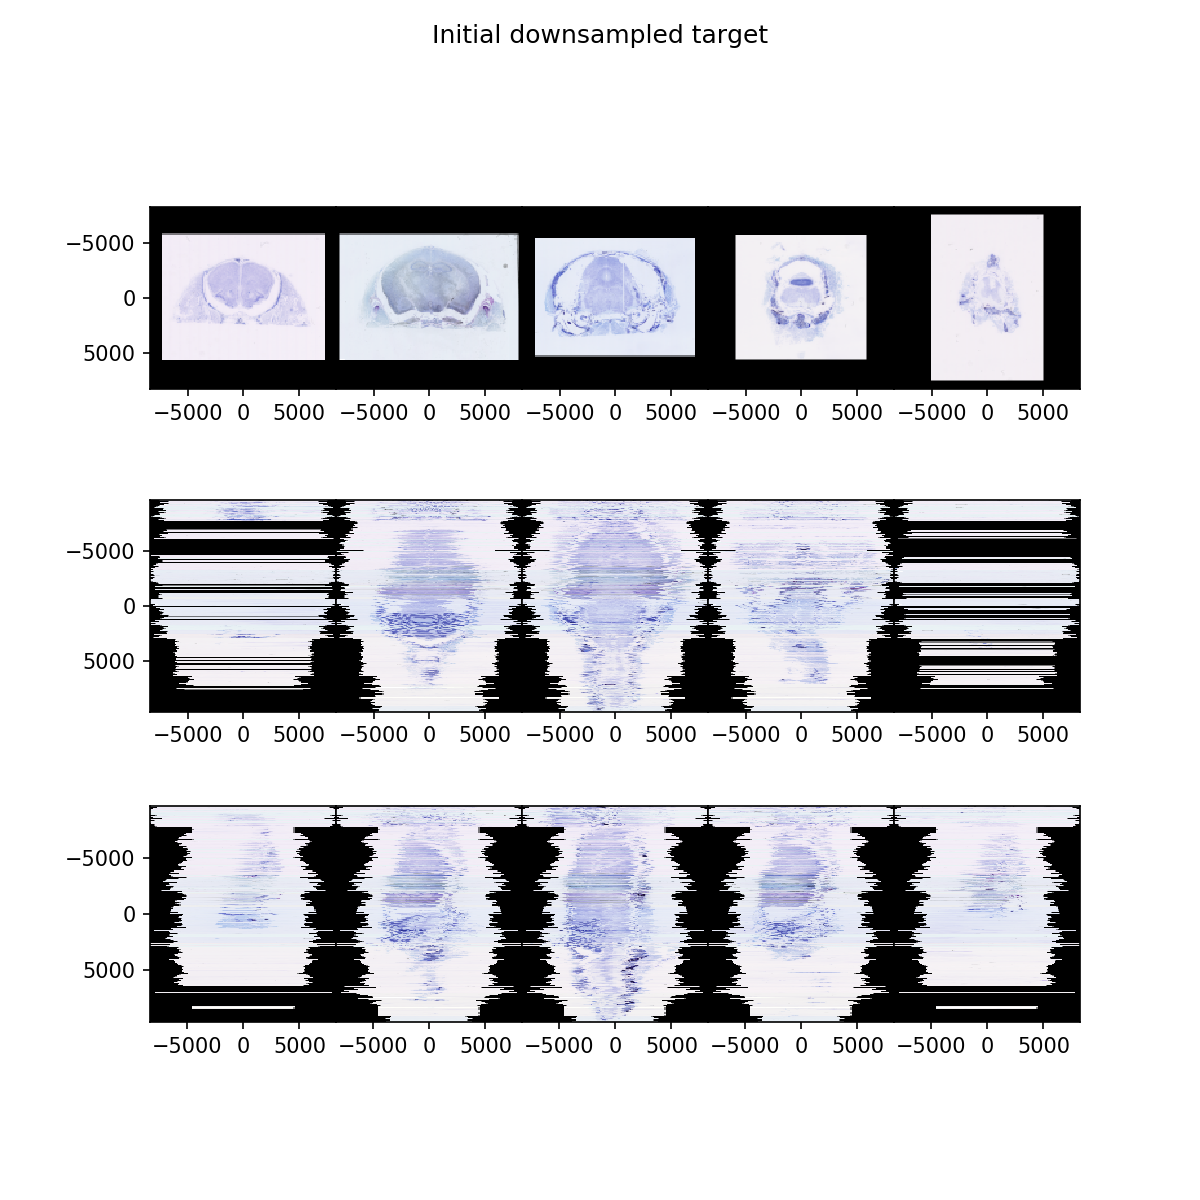

In [10]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')
fig[0].canvas.draw()

<IPython.core.display.Javascript object>


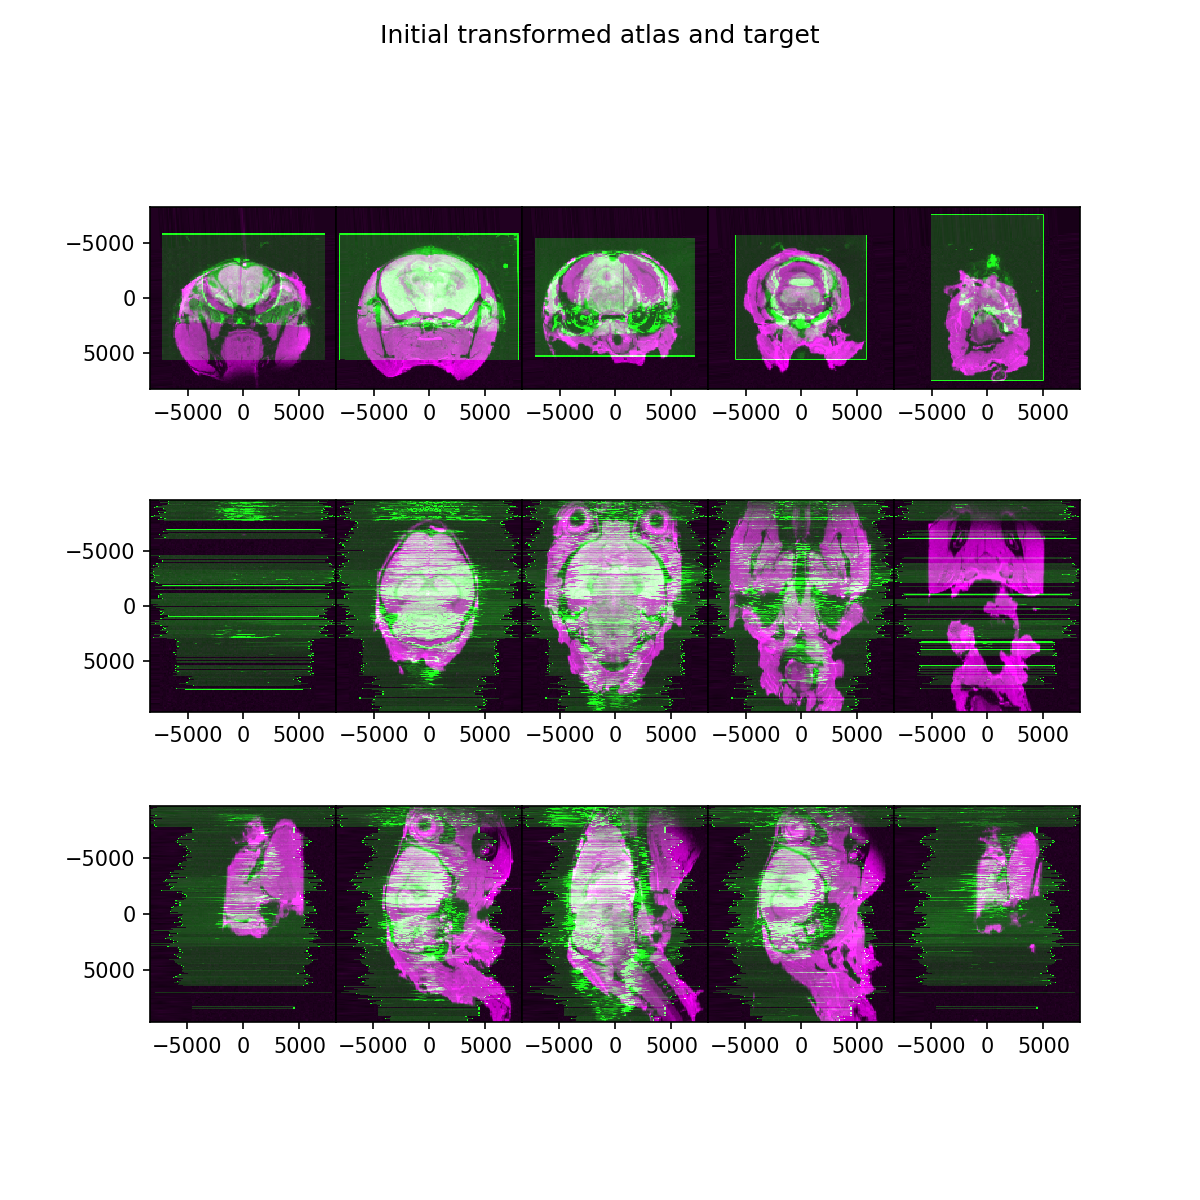

In [11]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)

# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]    
# we need to add some shift for better initial guess
A[0,-1] = 1100.0 # a positive number shifts MRI from A to P
A[1,-1] = 1900.0 # a positive number shifts MRI from S to I
A[2,-1] = 100.0 # a positive number shifts mri from R to L (i.e. to the right in our figs)
theta0 = -5.0*np.pi/180 # rotates around z axis
theta1 = 0.0*np.pi/180 # nose up or down
theta2 = 0.0*np.pi/180
A0 = np.array([[1.0,0.0,0.0,0.0],
               [0.0,np.cos(theta0),-np.sin(theta0),0.0],
               [0.0,np.sin(theta0),np.cos(theta0),0.0],
               [0.0,0.0,0.0,1.0]])
A1 = np.array([[np.cos(theta1),0.0,np.sin(theta1),0.0],
               [0.0,1.0,0.0,0.0],
               [-np.sin(theta1),0.0,np.cos(theta0),0.0],
               [0.0,0.0,0.0,1.0]])
As = np.diag([0.95,0.95,0.95,1.0])
A = A@A0@A1@As
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
#fig = emlddmm.draw(out,xJ)
#fig[0].suptitle('Initial transformed atlas')
#fig[0].canvas.draw()

toshow = np.stack((out[0]/np.quantile(I,0.99),(1.0-np.mean(J,0))*W0*4.0,out[0]/np.quantile(I,0.99)))
fig,ax = emlddmm.draw(toshow,xJ,vmin=0,vmax=1)
fig.suptitle('Initial transformed atlas and target')
fig.canvas.draw()


In [12]:
# list the config options
for k in config:
    print(f'{k} : {config[k]}')

n_iter : [100, 50]
downI : [[2, 2, 2], [1, 1, 1]]
downJ : [[1, 2, 2], [1, 1, 1]]
priors : [[0.9, 0.05, 0.05]]
sigmaM : [0.1]
sigmaB : [0.2]
sigmaA : [0.5]
sigmaR : [1000.0]
ev : [0.0005]
eA : [500000.0, 100000.0]
eA2d : [200.0, 50.0]
slice_matching : [1]
update_muA : [0]
update_muB : [0]
muA : [[0.1, 0.1, 0.1]]
muB : [[0.9, 0.9, 0.9]]
update_sigmaM : [0]
update_sigmaA : [0]
update_sigmaB : [0]
order : [3]
n_draw : [50]
n_e_step : [3]
slice_matching_start : [30, 0]
v_start : [10000, 0, 0]
A : [[[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]]


In [13]:
config = {
'device' : 'cuda:1',
'n_iter' : 1000,
'downI' : [2, 2, 2],
'downJ' : [1, 2, 2],
'priors' : [0.5, 0.1, 0.4],
'sigmaM' : 0.1,
'sigmaB' : 0.15,
'sigmaA' : 0.4,
'sigmaR' : 1000.0,
'ev' : 0.0005,
'eA' : 500000.0,
'eA2d' : 200.0,
'slice_matching' : 1,
'update_muA' : 1,
'update_muB' : 1,
'muA' : [0.1, 0.1, 0.1],
'muB' : [0.95, 0.93, 0.97],
'update_sigmaM' : 0,
'update_sigmaA' : 0,
'update_sigmaB' : 0,
'order' : 3,
'n_draw' : 50,
'n_e_step' : 3,
'slice_matching_start' : 30,
'v_start' : 10000,
'full_outputs' : 1,
    'Amode':1,
}

dv tensor([200., 200., 200.], device='cuda:1')
a scale is 400.0


<IPython.core.display.Javascript object>


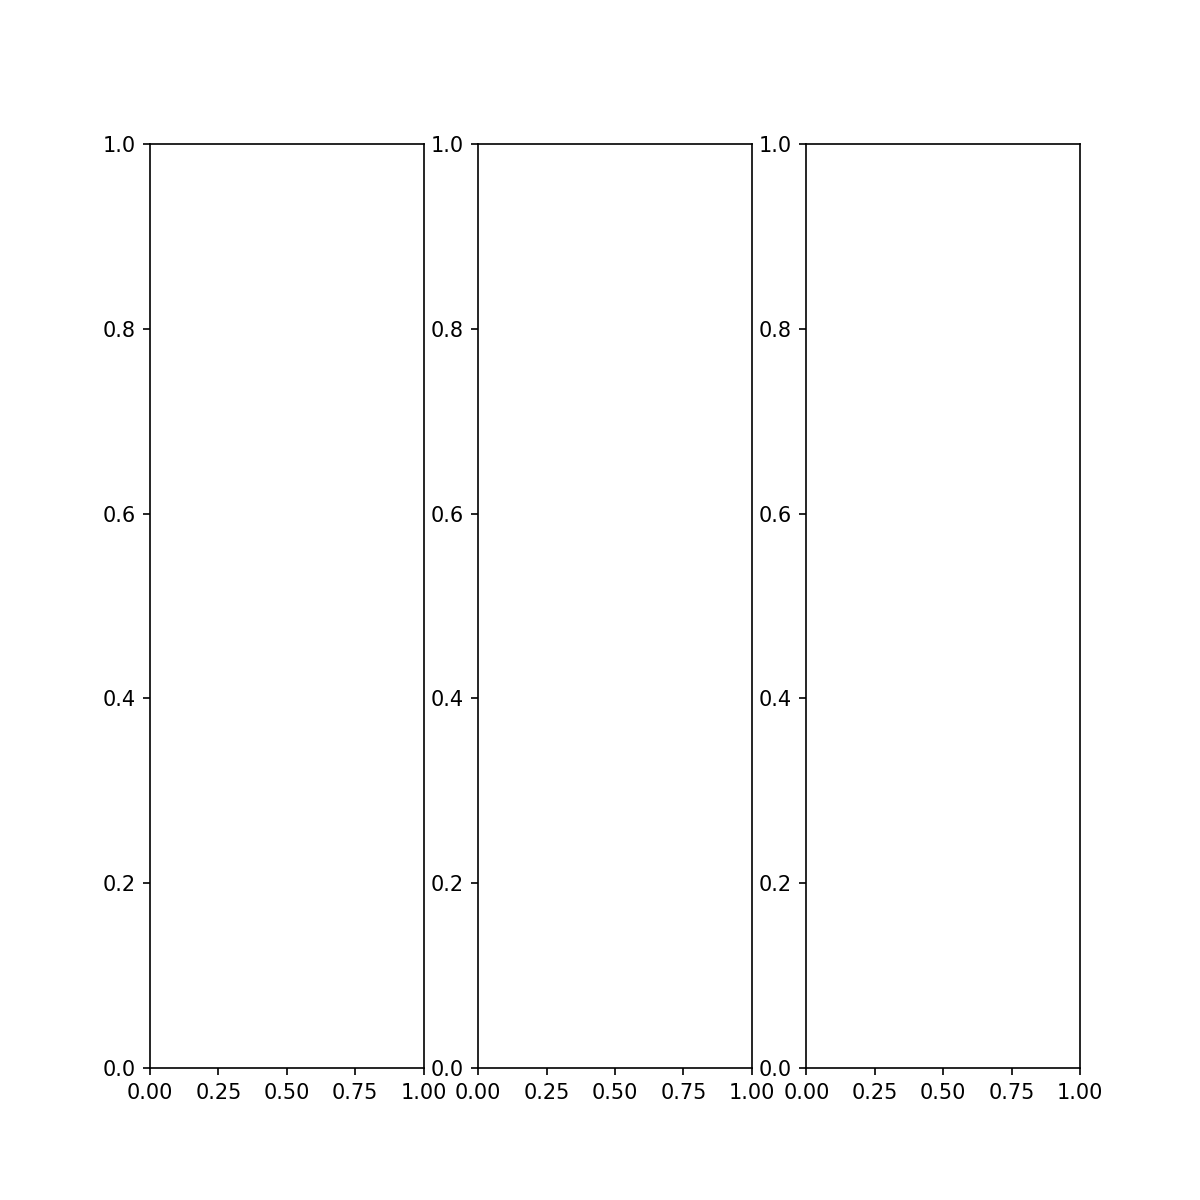

<IPython.core.display.Javascript object>


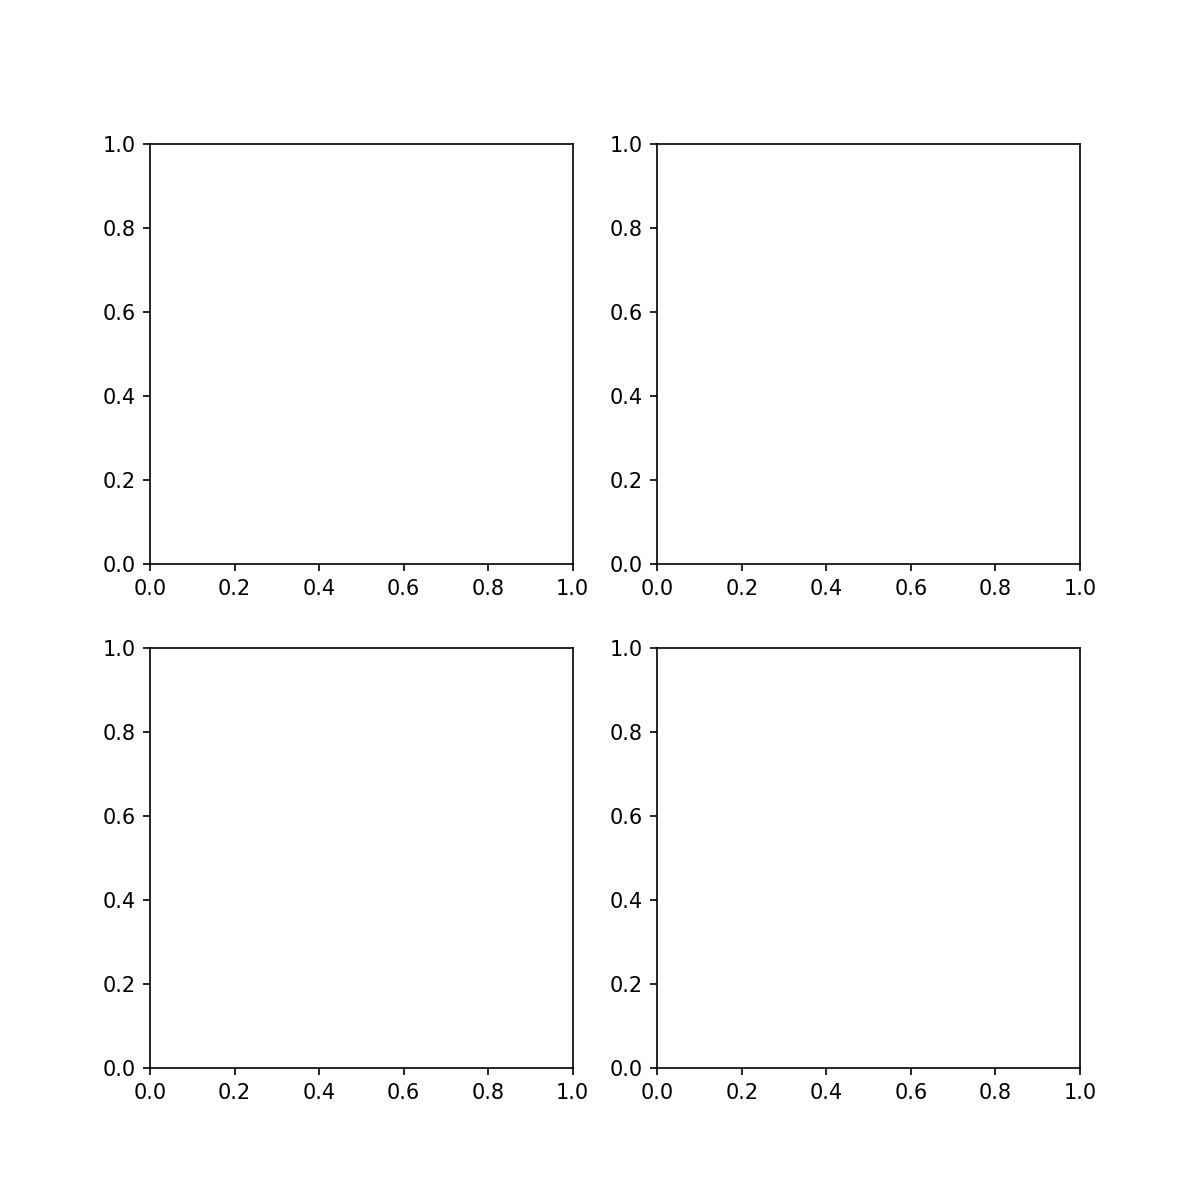

<IPython.core.display.Javascript object>


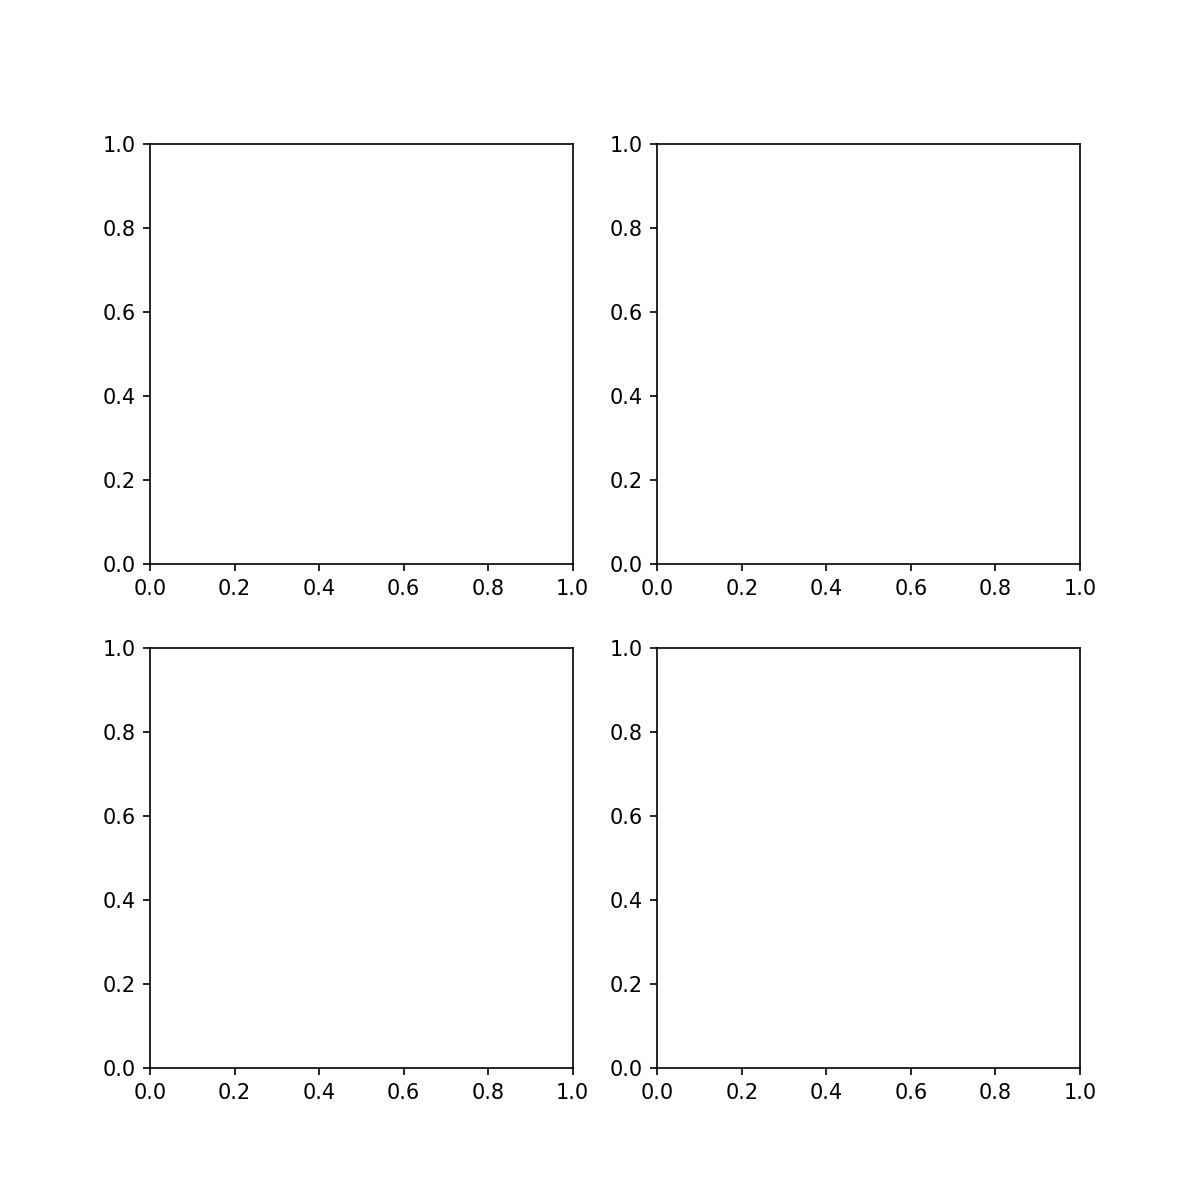

<IPython.core.display.Javascript object>


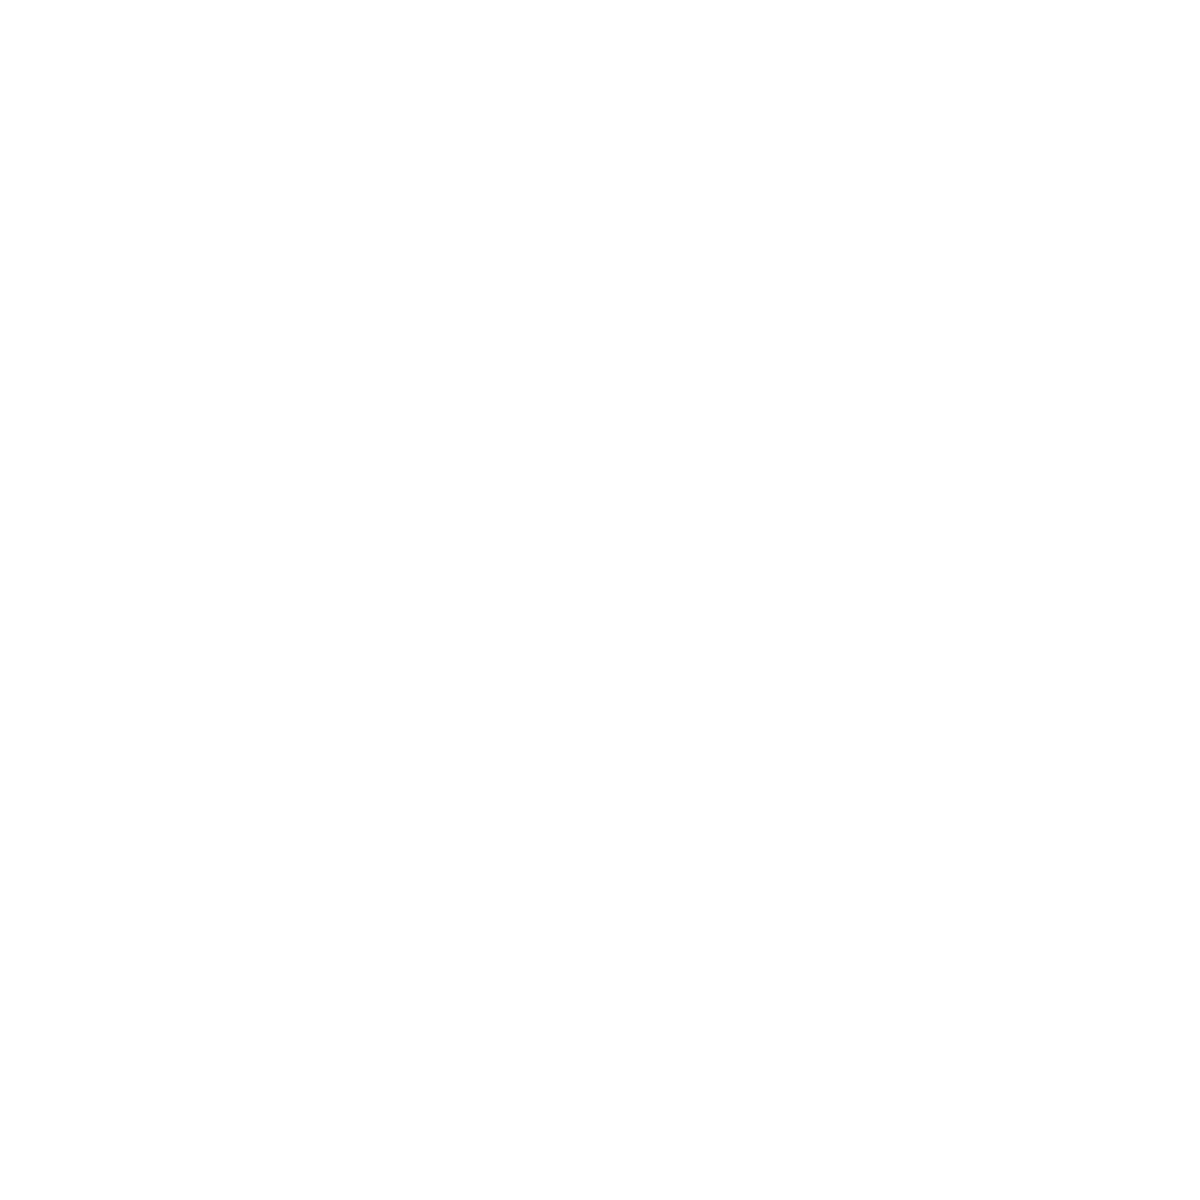

<IPython.core.display.Javascript object>


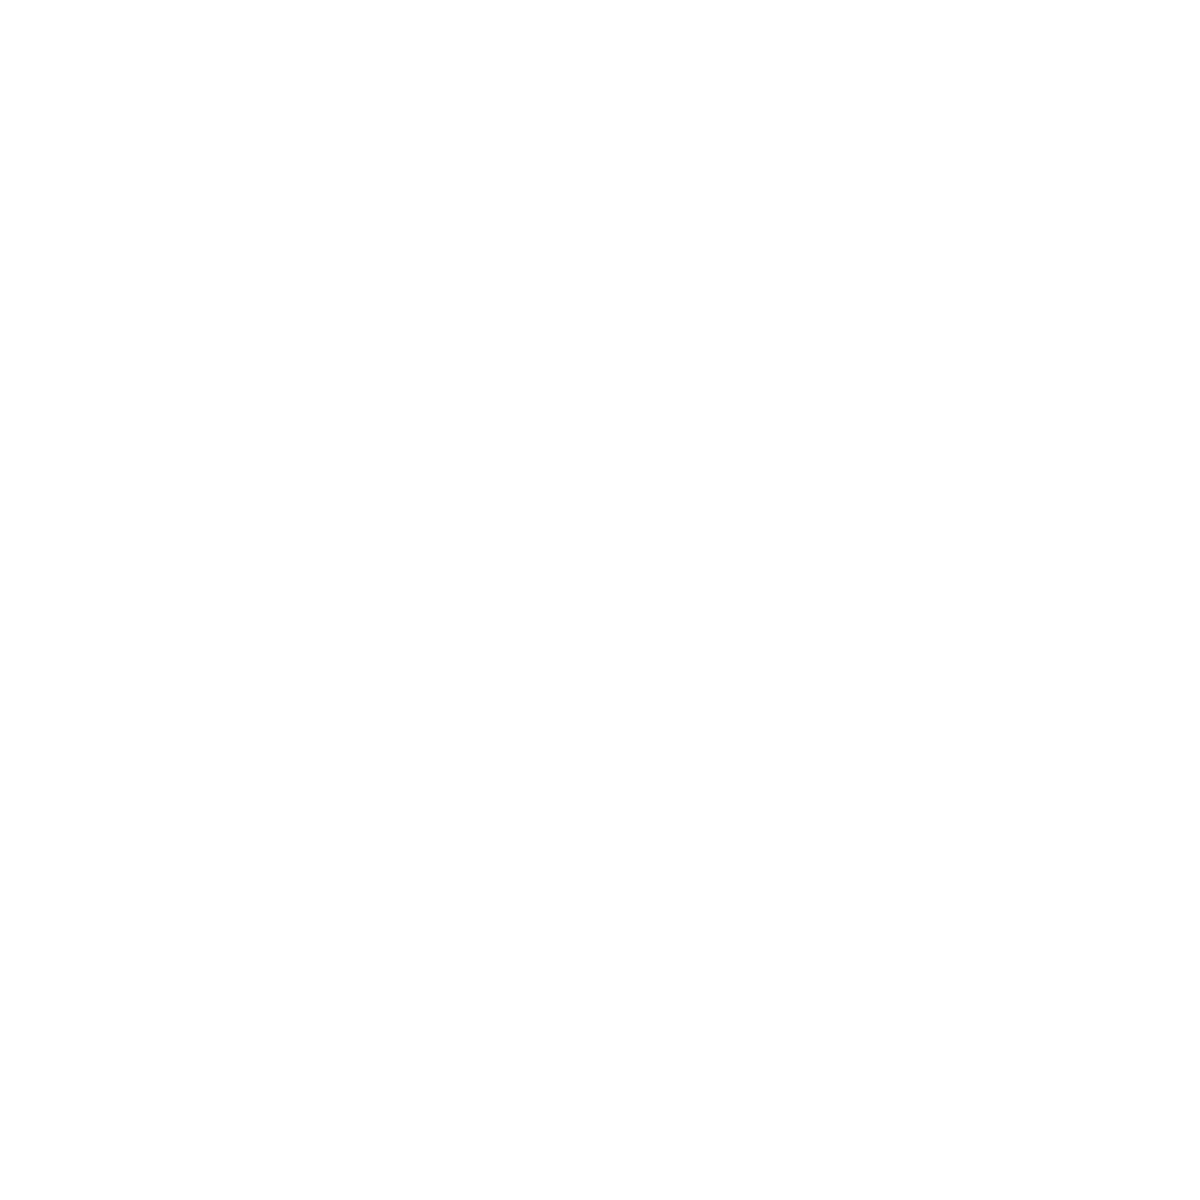

<IPython.core.display.Javascript object>


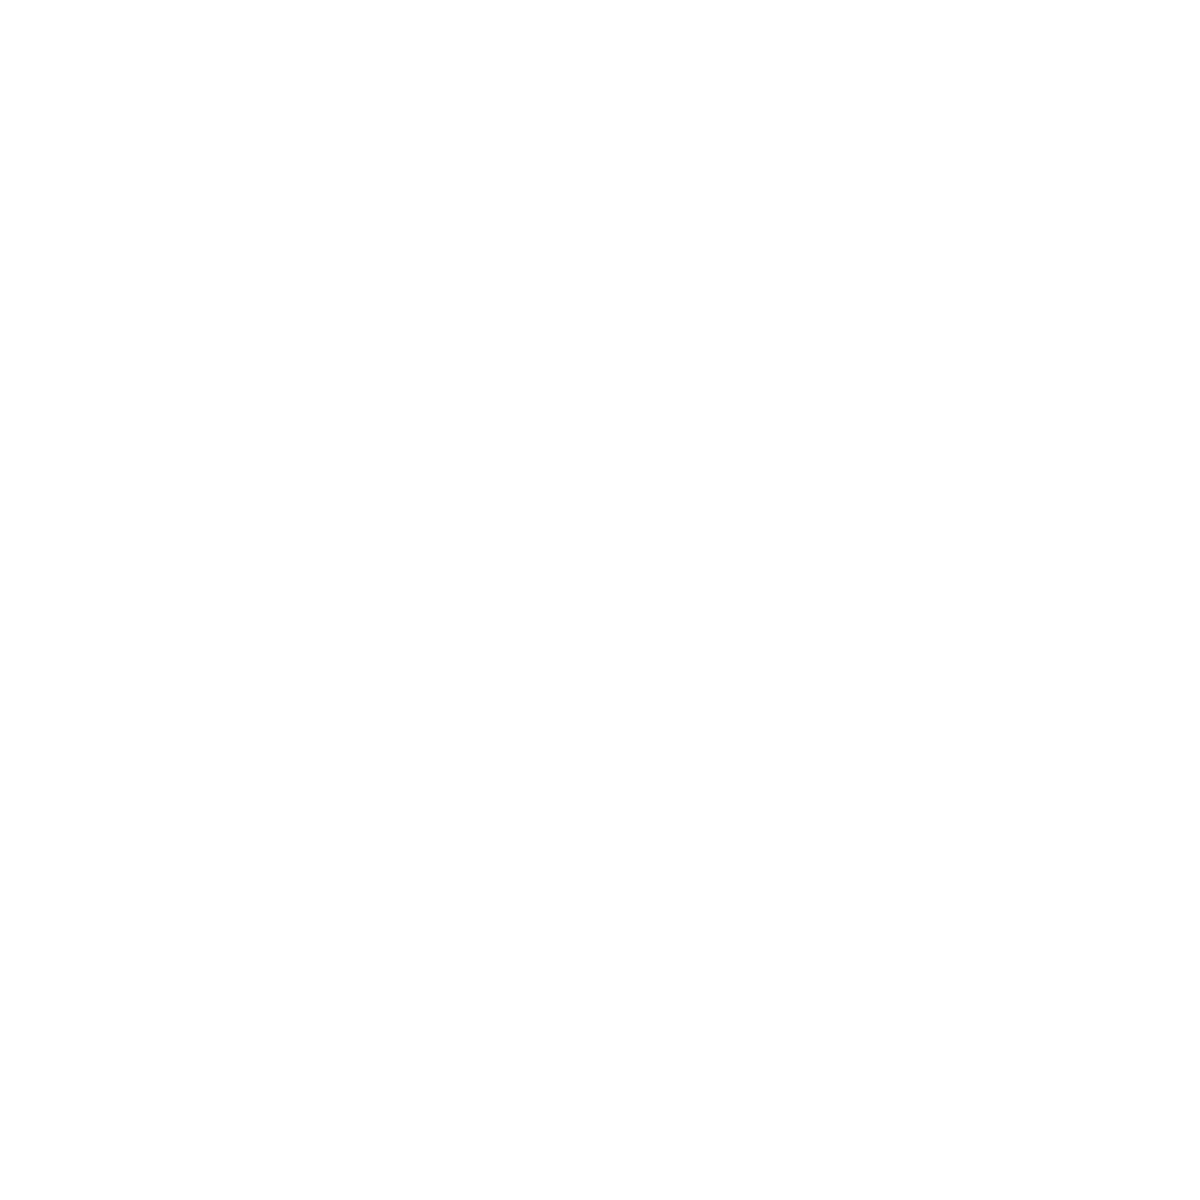

<IPython.core.display.Javascript object>


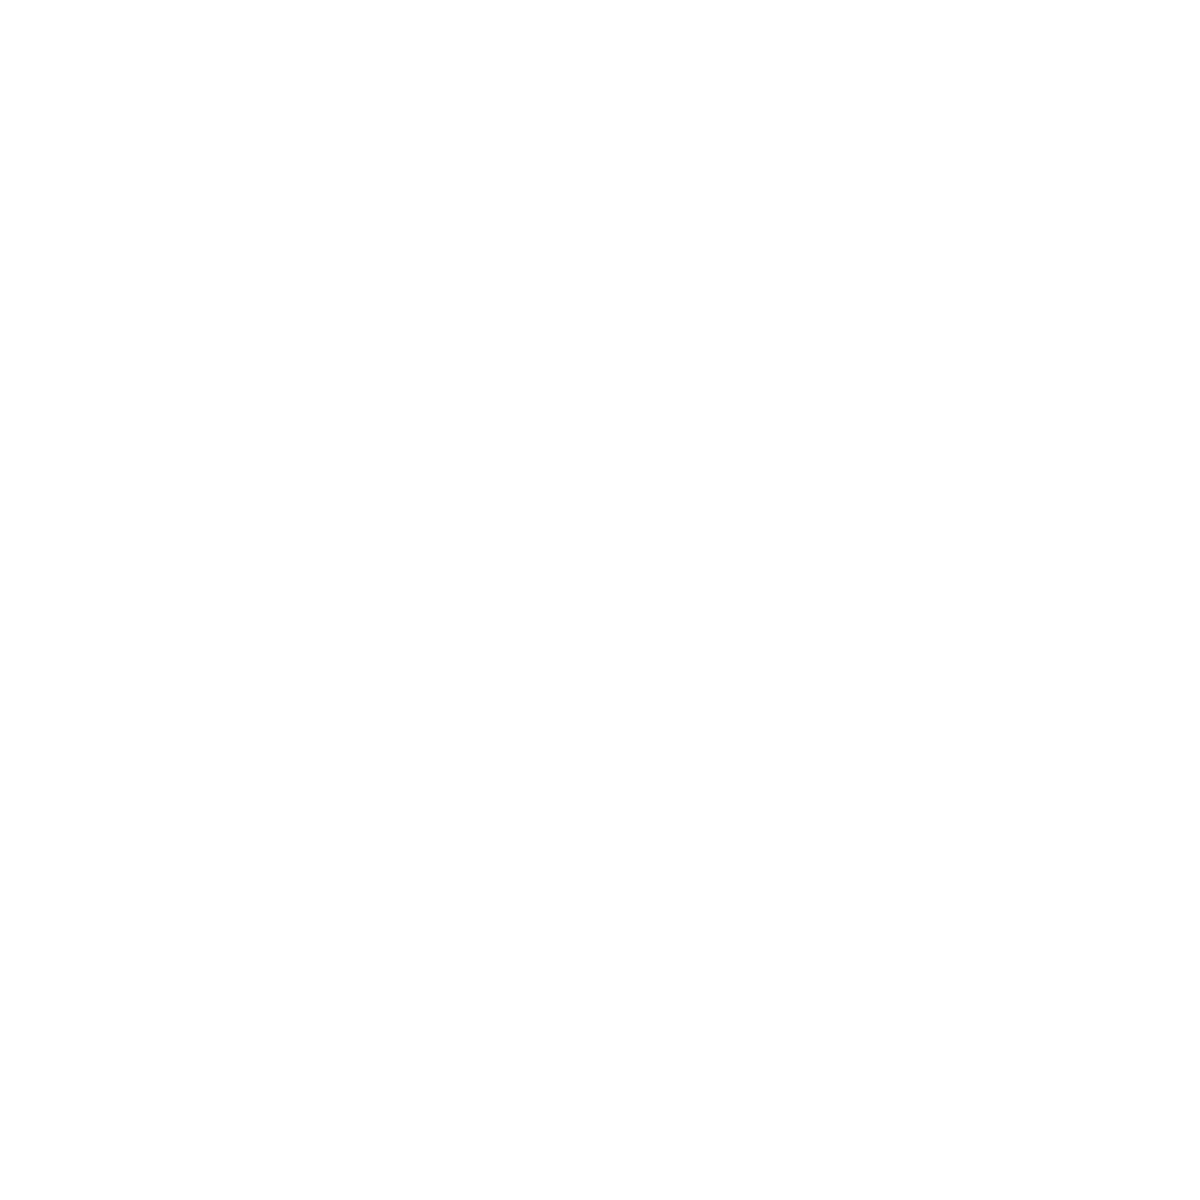

<IPython.core.display.Javascript object>


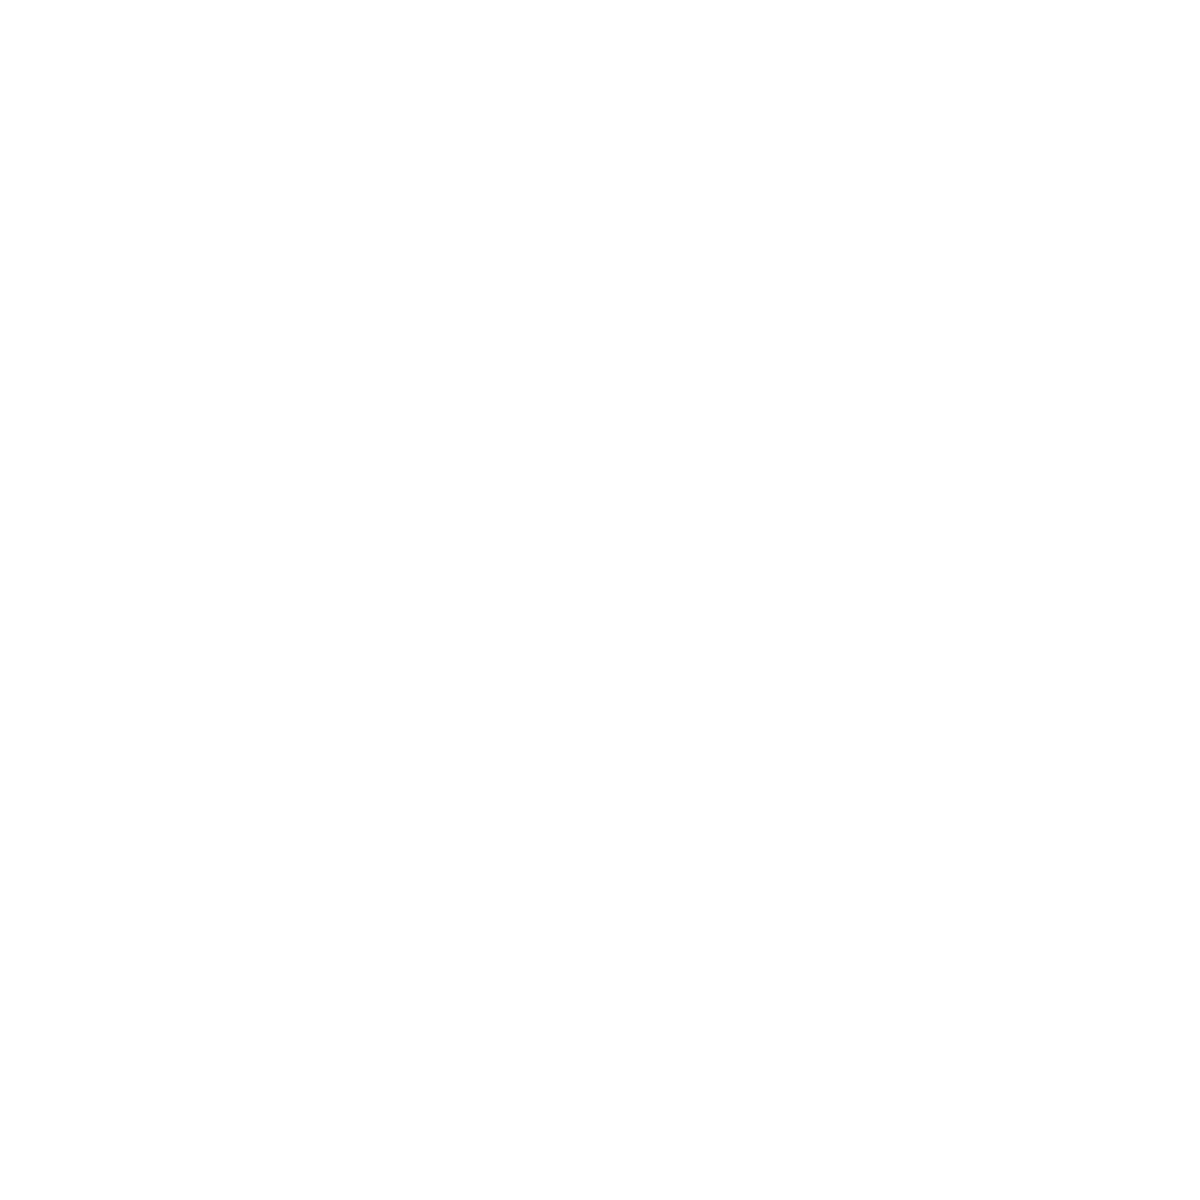

<IPython.core.display.Javascript object>


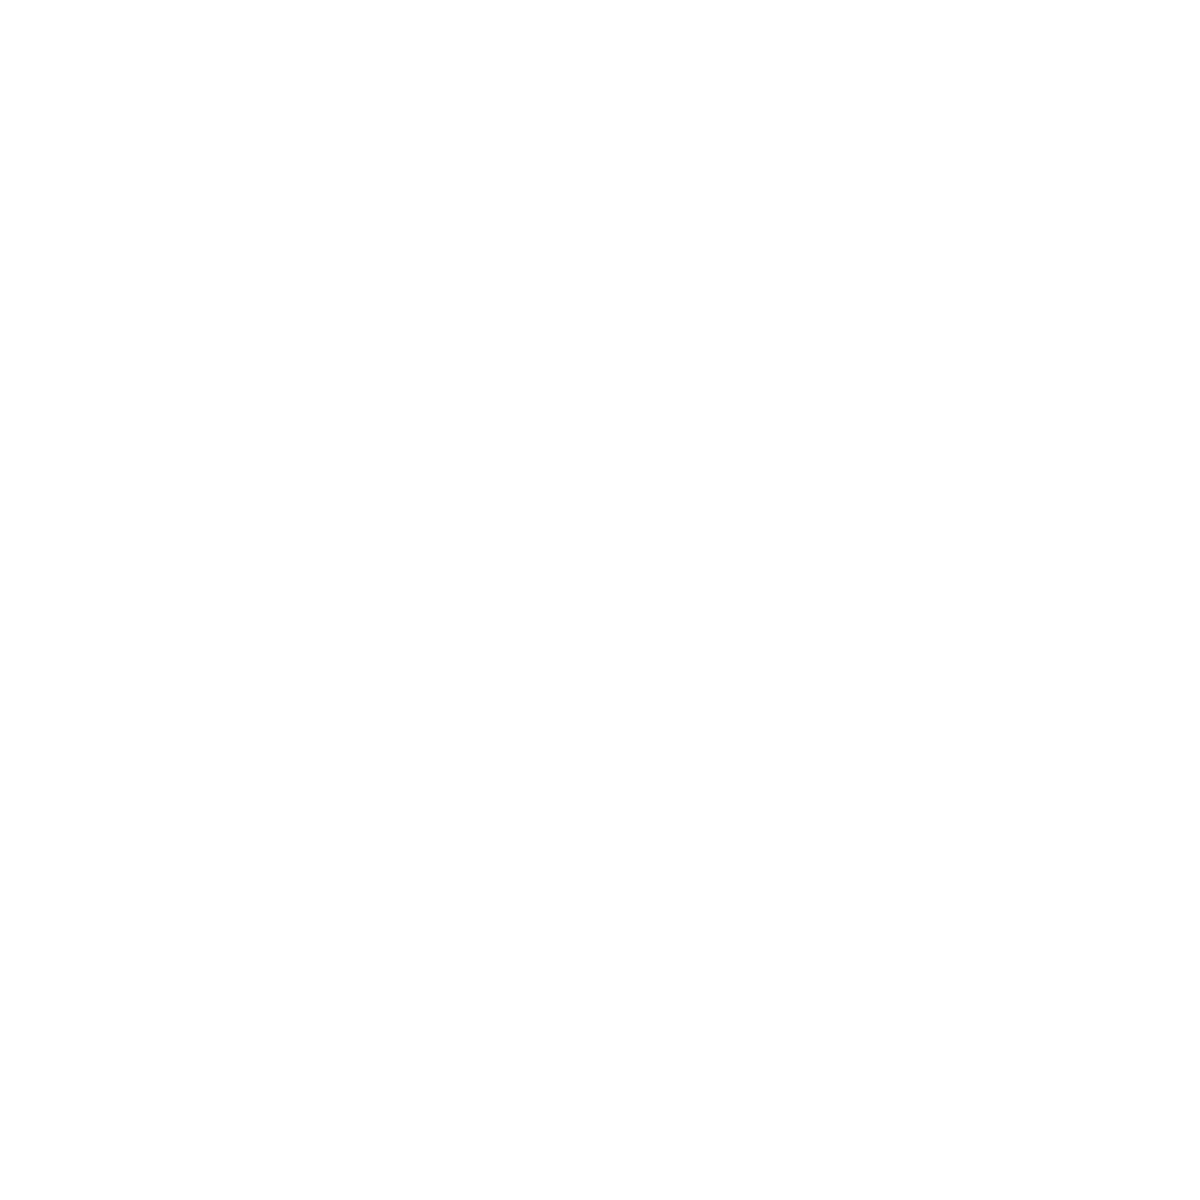

torch.Size([320, 4, 4]) torch.Size([320, 4, 3])
tensor([[[ 1.4120,  1.4206,  1.1328],
         [-2.2197, -2.1373, -0.8641],
         [ 2.4042,  2.3067,  0.9198],
         [-0.8227, -0.7848, -0.3005]],

        [[ 1.1481,  1.1037,  0.9733],
         [-0.8695, -0.7418, -0.1077],
         [ 0.8590,  0.6913,  0.0742],
         [-0.2666, -0.1978, -0.0097]],

        [[ 0.9980,  0.9905,  0.8872],
         [-0.3532, -0.3818,  0.1749],
         [ 0.3060,  0.3383, -0.2177],
         [-0.0828, -0.0936,  0.0839]],

        ...,

        [[ 0.8428,  0.8663,  0.8931],
         [ 0.1059,  0.1065,  0.0927],
         [-0.0576, -0.0580, -0.0516],
         [ 0.0079,  0.0079,  0.0069]],

        [[ 0.8369,  0.8602,  0.8812],
         [ 0.1494,  0.1512,  0.1585],
         [-0.0995, -0.1008, -0.1073],
         [ 0.0178,  0.0181,  0.0196]],

        [[ 0.8587,  0.8844,  0.9058],
         [ 0.1225,  0.1242,  0.1197],
         [-0.0918, -0.0935, -0.0921],
         [ 0.0172,  0.0175,  0.0174]]], device='cuda:1

Exception: 

In [18]:
import imp
imp.reload(emlddmm)
output = emlddmm.emlddmm(I=I,xI=xI,J=J,xJ=xJ,W0=W0,A=A,**config)

In [ ]:
[h for h in output]

In [ ]:
import imp
imp.reload(emlddmm)
emlddmm.write_outputs_for_pair(output_dir,output,xI,I,xJ,J,
                               atlas_space_name='invivoMRI',atlas_image_name='M1',
                              target_space_name='histology',target_image_name='Nissl')

In [ ]:
[h for h in output]

In [ ]:
emlddmm.write_transform_outputs(output_dir,output)

In [ ]:
# get labels
imp.reload(emlddmm)
xS,S,title,names = emlddmm.read_data(label_name,endian='l')
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))

In [ ]:
# save config used to output
with open(config_file) as f:
    config = json.load(f)
with open(os.path.join(output_dir, 'config.json'), 'w') as f:
    json.dump(config, f)